# Tutorial 4 - Pioneer
This tutorial models a potential design for a WEC used to provide power to instruments in the [Pioneer Central Surface Mooring System](https://oceanobservatories.org/site/cp01cnsm/) within the [Coastal Pioneer Array](https://oceanobservatories.org/array/coastal-pioneer-array/) off the coast of New England. This system has instrumentation to measure various meteorological, surface, near-surface, and seabed phenomena on the Continental Shelf-Slope and transmit back to shore.

Unlike previous tutorials, this tutorial does not include an outer optimization loop. Instead, the focus here is on effectively modeling an optimization problem for the control of a unique WEC archetype with a pitch resonator PTO with several co-dependent components. This is completely setup in Part 1, and includes:

* Expanding the control state vector
* Custom PTO physics
* Modeling non-hydrodynamic degrees of freedom

This tutorial is divided into three parts. The first sets up the problem including the points above. The second and third show results using a regular and irregular wave, respectively.

1. [Model setup](#1.-Model-setup)
2. [Regular wave results](#2.-Regular-wave-results)
3. [Irregular wave](#3.-Irregular-wave)


<p><img src=https://oceanobservatories.org/wp-content/uploads/2015/09/Central-Surface-Mooring-Array-01-1.png alt="Diagram of the Pioneer device" width="307"></p>

In [53]:
import capytaine as cpy
import autograd.numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import xarray as xr

import wecopttool as wot

## set colorblind-friendly colormap for plots
plt.style.use('tableau-colorblind10')

## 1. Model setup

### 1.1 Waves
We start with the setting up the different waves we want to model, as this will inform what to select for our frequency range, which we need throughout the rest of the problem setup. 
We will consider two waves: a regular wave and an irregular wave, both with typical characteristics of the deployment site. The regular wave is roughly at 0.35 Hz, the known pitch resonance frequency of the buoy. The irregular wave has a peak period of 5 seconds, matching that of the deployment site.

In [54]:
f1 = 0.025 # Hz
nfreq = 75

In [55]:
# regular
amplitude = 0.15
wavefreq = 0.35
waves_regular = wot.waves.regular_wave(f1, nfreq, wavefreq, amplitude)

# irregular
Hs = 1.5
Tp = 5 

fp = 1/Tp
spectrum = lambda f: wot.waves.pierson_moskowitz_spectrum(f, fp, Hs)
efth = wot.waves.omnidirectional_spectrum(f1, nfreq, spectrum, "Pierson-Moskowitz")
waves_irregular = wot.waves.long_crested_wave(efth, nrealizations = 5)

We plot the wave elevation spectra to check if the chosen frequency array covers the main excitation frequency, converges to zero for larger frequencies and can capture multiple harmonics which are required for nonlinear dynamics, since the states are multiplied with each other.
If the plot below does not cover the desired frequencies please adjust the frequency array.

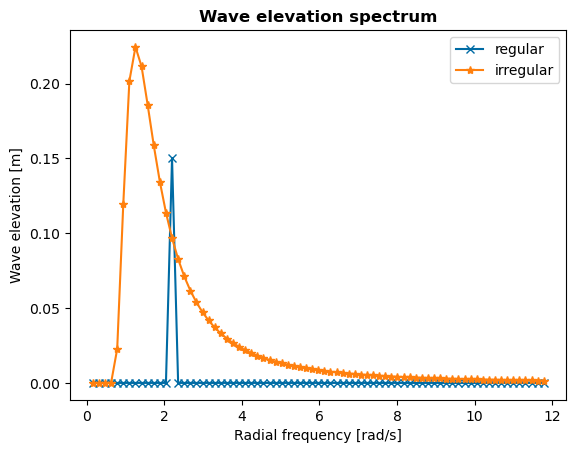

In [56]:
#TODO: highlight the harmonics if wave freq and Tp with other markers+colors
fig, ax = plt.subplots()
np.abs(waves_regular).plot(marker = 'x', label="regular")
np.abs(waves_irregular.sel(realization=0)).plot(marker = '*', label="irregular")
ax.set_title('Wave elevation spectrum', fontweight='bold')
plt.legend()

### 1.2 Basic properties
#### Geometry
To get the required hydrodynamic coefficients of the Pioneer design, we only need to be concerned with creating a mesh of the buoy geometry. The buoy has the same general shape as the WaveBot used in Tutorial 1, so we will use the build-in `geom.WaveBot` object and change the dimensions to simplify the mesh creation process.

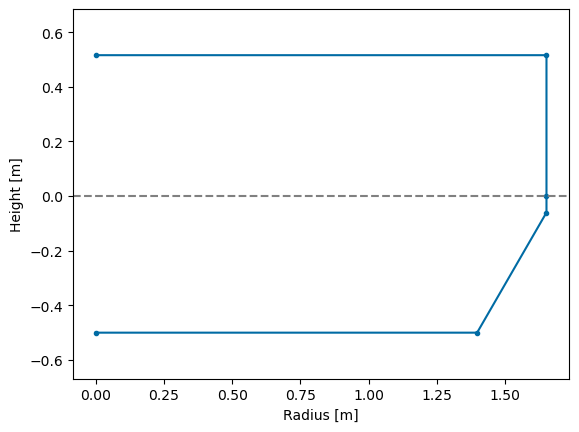

In [57]:
in2m = 0.0254 # inch -> meter conversion factor
draft = 0.5 # meters
freeboard = 40. * in2m - draft
hull_geom = wot.geom.WaveBot(r1=130./2 * in2m,
                             r2=110./2 * in2m, 
                             h1=22.679 * in2m,
                             h2=17.321 * in2m,
                             scale_factor=1,
                             freeboard=freeboard)
mesh = hull_geom.mesh(mesh_size_factor=0.5)
_ = hull_geom.plot_cross_section()

#### Design properties
The Pioneer team has developed initial specifications for a full-sized WEC design that fits within the buoy dimensions and operating at resonance. There are several components that we need to capture in the PTO model:

* **Buoy**: As mentioned, this has the same basic geometric parameters as the WaveBot used in Tutorial 1. Since we're only modeling the pitch degree of freedom, we only need the pitch moment of inertia and not the mass of the buoy.
* **Flywheel**: The flywheel is contained and dimensioned to fit on top of the buoy. It rotates in pitch independently of the buoy, but is linked to the buoy through two parallel connections: the torsional spring and the generator. Since the flywheel is protected from wave loading by the buoy, it is **not** subject to hydrostatics or hydrodynamics.
* **Spring**: The magnetic torsional spring provides positive stiffness to the flywheel. It has a linear displacement up to 45 degrees, at which point it "wraps around" and the stiffness begins decreasing. For simplicity, we will model the spring as strictly linear. The spring is connected to a gearbox which makes the position of the spring (and therefore, the generator shaft) different from the relative position of the flywheel and buoy. 

A rendering of the Pioneer WEC model is shown here with the buoy pitch in red and the flywheel pitch in green:
<p><img src=https://live.staticflickr.com/65535/53025745404_2e75c89894_k.jpg alt="Diagram of the Pioneer device" width="500"></p>

In [58]:
buoy_props = {
    'CG': 0.242, # m
    'MOI': 7484., # kg-m^2
    'Resonance frequency': 0.35, # Hz
}

flywheel_props = {
    'MOI': 25,  # kg-m^2
    'Coulomb friction': 2.0,  # N-m
    'Viscous friction': 0.02,  # N-m/rad
    'Gear ratio': 3, # -
}

spring_props = {
    'Max torque': 750, # N-m
    'Max displacement': np.deg2rad(45.0), # rad
}

#### Pitch resonator
This system uses a unique PTO system, where the generator velocity is dependent on the relative pitching rotation of the buoy and the flywheel. The system can be modeled as a coupled spring-mass-damper system, with the generator represented as $B_{PTO}$. The spring-mass-damper system and equivalent circuit model are shown below. Note that all of these values are rotational and are drawn here linearly for simplicity. 

<p><img src=https://live.staticflickr.com/65535/53025028262_1a4ba2d5ce_z.jpg alt="Pioneer model as a spring-mass-damper system" width="500"> <img src=https://live.staticflickr.com/65535/53025140497_29c5b9d601_z.jpg alt="Pioneer model as a spring-mass-damper system" width="180"></p>

This corresponds to the following dynamics equations:

(1) $$ [J_{buoy} + J(\omega))] \ddot{\theta}_{buoy} = T_{hydro} - K_{hydro}\theta_{buoy} - B(\omega)\dot{\theta}_{buoy} - K_{spring}(\theta_{buoy} - \theta_{flywheel})/N^2 - (B_{PTO} + B_{fric})(\dot{\theta}_{buoy} - \dot{\theta}_{flywheel}) $$

(2) $$ J_{flywheel} \ddot{\theta}_{flywheel} = K_{spring}(\theta_{buoy} - \theta_{flywheel})/N^2 + (B_{PTO} + B_{fric})(\dot{\theta}_{buoy} - \dot{\theta}_{flywheel}) $$

We will explore how to capture these dynamics in WecOptTool in the following sections.

#### Hydrodynamics and hydrostatics
As mentioned above, the `FloatingBody` object in Capytaine only needs to model the buoy, since no other components are being excited by the waves. The inertia matrix needs to be defined manually here since it is not based on the displaced mass.

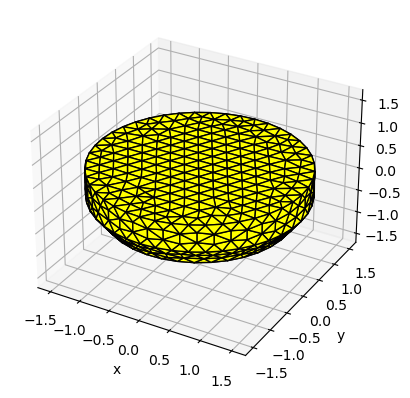

In [59]:
pnr_fb = cpy.FloatingBody.from_meshio(mesh, name="Pioneer")
pnr_fb.add_rotation_dof(name='Pitch')
pnr_fb.center_of_mass = np.array([0., 0., buoy_props['CG']])
pnr_fb.rotation_center = pnr_fb.center_of_mass
ndof = pnr_fb.nb_dofs
pnr_fb.show_matplotlib()

pnr_fb.inertia_matrix = xr.DataArray([[buoy_props['MOI']]],
                            dims=['influenced_dof', 'radiating_dof'],
                            coords={'influenced_dof' : ['Pitch'],
                            'radiating_dof' : ['Pitch']},
                            name="inertia_matrix"
                            )

In [60]:
rho = 1025. # kg/m^3
freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency
bem_data = wot.run_bem(pnr_fb, freq, rho=rho)
omega = bem_data.omega.values

pnr_fb.keep_immersed_part()
k_spring = spring_props['Max torque'] / spring_props['Max displacement']
print(f"Hydrostatic stiffness from Capytaine: {bem_data['hydrostatic_stiffness'].values.squeeze()} N-m/rad")
print('Hydrostatic stiffness from experiment: 37204 N-m/rad')

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.35e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.29e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.23e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.18e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.10e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.91e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.73e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.56e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.40e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.24e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.89e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.57e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.26e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel 

('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.29e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.10e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.91e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.73e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.56e-01.
This warning appears because the largest panel 

Hydrostatic stiffness from Capytaine: 40408.752778872986 N-m/rad
Hydrostatic stiffness from experiment: 37204 N-m/rad


As with previous tutorials, we will plot the hydrodynamic coefficients to confirm that we are properly capturing the full excitation range of the buoy.

Text(0.5, 1.0, 'Radiation Damping Coefficients')

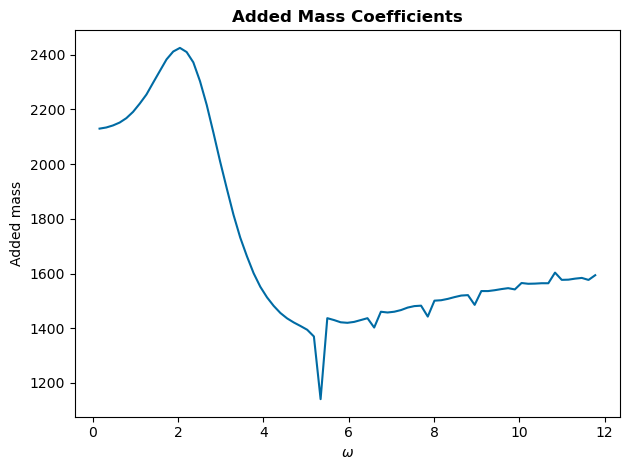

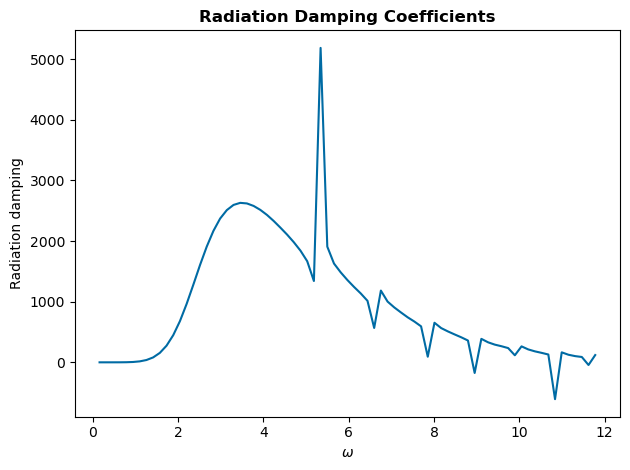

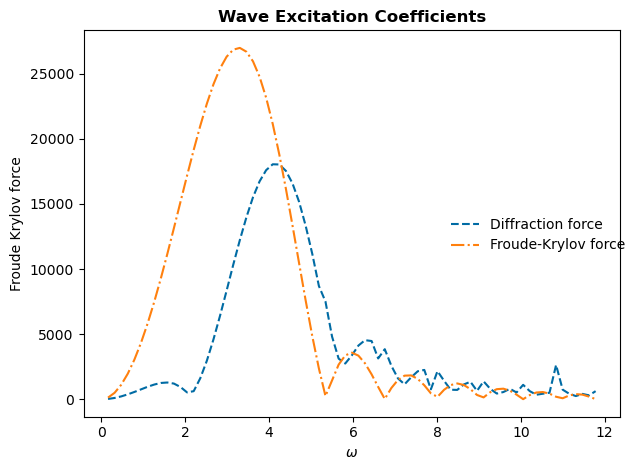

In [61]:
# Plots
fig_am, ax_am = plt.subplots(tight_layout=True, sharex=True)
fig_rd, ax_rd = plt.subplots(tight_layout=True, sharex=True)
fig_ex, ax_ex = plt.subplots(tight_layout=True, sharex=True)

# Excitation
np.abs(bem_data.diffraction_force.sel(influenced_dof='Pitch')).plot(
    ax=ax_ex, linestyle='dashed', label='Diffraction force')
np.abs(bem_data.Froude_Krylov_force.sel(influenced_dof='Pitch')).plot(
    ax=ax_ex, linestyle='dashdot', label='Froude-Krylov force')
ex_handles, ex_labels = ax_ex.get_legend_handles_labels()
ax_ex.set_xlabel(f'$\omega$', fontsize=10)
ax_ex.set_title('Wave Excitation Coefficients', fontweight='bold')
fig_ex.legend(ex_handles, ex_labels, loc='center right', frameon=False)

# Added mass
bem_data.added_mass.sel(
    radiating_dof='Pitch', influenced_dof='Pitch').plot(ax=ax_am)
ax_am.set_xlabel(f'$\omega$', fontsize=10)
ax_am.set_title('Added Mass Coefficients', fontweight='bold')

# Radiation damping
bem_data.radiation_damping.sel(
    radiating_dof='Pitch', influenced_dof='Pitch').plot(ax=ax_rd)
ax_rd.set_xlabel(f'$\omega$', fontsize=10)
ax_rd.set_title('Radiation Damping Coefficients', fontweight='bold')

### 1.3 PTO
The generator shaft velocity is the difference between the buoy velocity and the flywheel velocity. Because the velocity PTO depends not only on the hydrodynamic states (`x_wec`, buoy pitch) but also on an additional non-hydrodynamic state (flywheel pitch), we cannot use the `PTO` module we have used in previous tutorials. Instead, we will make two adjustments to our model compared to previous tutorials:

1. We will adjust the `x_opt` vector to include the flywheel motion
2. We will manually define the equations for the PTO dynamics and energy equations

#### Capturing flywheel motions
In previous tutorials, all the relevant WEC dynamics have been captured in the `x_wec` vector. However, `x_wec` assumes all the degrees of freedom are excited by waves, which is not the case for the flywheel in the Pioneer model.

The `x_opt` vector has previously only been used to model the PTO force. However, there is no limit to what `x_opt` can include; it can theoretically include anything that is needed to model the PTO control. Since we need to capture the flywheel dynamics to properly model the PTO, we will append the Fourier coefficients of the flywheel's position to `x_opt`. The first part of `x_opt` will continue to be used for the PTO force (e.g. Fourier coefficients of the force time-series for an unstructured controller). 

Note in the code further down that `x_opt` will be spliced as either `x_opt[:nstate_pto]` to exclude the flywheel position states, or `x_opt[nstate_pto:]` to exclude the PTO force states. Remember, `x_opt` can be defined arbitrarily, and specific meanings to the states are given elsewhere in the model.

In [62]:
nstate_pto = 2 * nfreq # PTO forces
nstate_fw = 2 * nfreq  # Flywheel positions
nstate_opt = nstate_pto + nstate_fw

#### Manually defining PTO equations
Instead of calling the `PTO` module, we will manually define the dynamics and energy equations needed for WecOptTool to calculate electrical power, our quantity of interest for this optimization problem. These equations are also needed for the additional forces and constraints defined later on.

##### Relative motion
Here we define functions for the relative motion of the buoy and flywheel, derived from `x_wec` and `x_opt` respectively.

In [63]:
def x_rel(wec, x_wec, x_opt):
    pos_wec = wec.vec_to_dofmat(x_wec)
    pos_fw = wec.vec_to_dofmat(x_opt[nstate_pto:])
    return pos_wec - pos_fw

def rel_position(wec, x_wec, x_opt, waves, nsubsteps=1):
    pos_rel = x_rel(wec, x_wec, x_opt)
    time_matrix = wec.time_mat_nsubsteps(nsubsteps)
    return np.dot(time_matrix, pos_rel)

def rel_velocity(wec, x_wec, x_opt, waves, nsubsteps=1):
    pos_rel = x_rel(wec, x_wec, x_opt)
    vel_rel = np.dot(wec.derivative_mat, pos_rel)
    time_matrix = wec.time_mat_nsubsteps(nsubsteps)
    return np.dot(time_matrix, vel_rel)

##### Unstructured controller
This is nearly identical to the `wot.pto.controller_unstructured` function, except `x_opt` is spliced to only include the first part, since we are also including the flywheel positions in the second part of `x_opt`.

In [64]:
def f_motor(wec, x_wec, x_opt, waves, nsubsteps=1):
    motor = np.reshape(x_opt[:nstate_pto], (-1, ndof), order='F')
    time_matrix = wec.time_mat_nsubsteps(nsubsteps)
    return np.dot(time_matrix, motor)

##### PTO Impedance
The PTO impedance is defined using the same 2-port impedance model as in previous tutorials. The drivetrain inertia, friction, and stiffness are not included here since they are accounted for in the modeling of the additional non-hydrodynamic degree of freedom, as additional forces and constraints below.

In [65]:
torque_constant = 3.512
winding_resistance = 0.304

z_11 = np.array([[np.zeros(omega.shape)]])
off_diag = np.sqrt(3.0/2.0) * torque_constant
z_12 = np.array([[-1*(off_diag+0j) * np.ones(omega.shape)]])
z_21 = np.array([[-1*(off_diag+0j) * np.ones(omega.shape)]])
z_22 = np.array([[winding_resistance * np.ones(omega.shape)]])

When using the `PTO` module, the 2x2 impedance matrix is passed to the `wot.pto.PTO` object and converted into a transfer matrix to calculate the power at each frequency. While we're not using the `PTO` module, we will repeat this process almost verbatim here; see the `_make_abcd` and `_make_mimo_transfer_mat` functions in the `PTO` module if you are interested in more technical details.

In [66]:
z_12_inv = np.linalg.inv(z_12.T).T
mmult = lambda a,b: np.einsum('mnr,mnr->mnr', a, b)
abcd_11 = -1 * mmult(z_12_inv, z_11)
abcd_12 = z_12_inv
abcd_21 = z_21 - mmult(z_22, mmult(z_12_inv, z_11))
abcd_22 = mmult(z_22, z_12_inv)
row_1 = np.hstack([abcd_11, abcd_12])
row_2 = np.hstack([abcd_21, abcd_22])
abcd = np.vstack([row_1, row_2])

for idof in range(2):
    for jdof in range(2):
        Zp = abcd[idof, jdof, :]
        re = np.real(Zp)
        im = np.imag(Zp)
        blocks = [np.array([[ire, iim], [iim, ire]])
                           for (ire, iim) in zip(re[:-1], im[:-1])]
        blocks = [re[0]] + blocks + [re[-1]]
        if jdof==0:
            row = block_diag(*blocks)
        else:
            row = np.hstack([row, block_diag(*blocks)])
    if idof==0:
        transfer_mat = row
    else:
        transfer_mat = np.vstack([transfer_mat, row])

##### Power and Energy
Finally, we will wrap the relative motions, force, and impedance functions together to calculate average electrical power. This is again very close to what is found in the `PTO` module, except `rel_velocity` replaces `wot.pto.PTO.velocity` and `f_motor` replaces `wot.pto.PTO.force`.

In [67]:
def mechanical_power(wec, x_wec, x_opt, waves, nsubsteps=1):
    force_td = f_motor(wec, x_wec, x_opt, waves, nsubsteps)
    vel_td = rel_velocity(wec, x_wec, x_opt, waves, nsubsteps)
    return vel_td * force_td

def electrical_power(wec, x_wec, x_opt, waves, nsubsteps=1):
    q1_td = rel_velocity(wec, x_wec, x_opt, waves)
    e1_td = f_motor(wec, x_wec, x_opt, waves)
    q1 = wot.complex_to_real(wec.td_to_fd(q1_td, False))
    e1 = wot.complex_to_real(wec.td_to_fd(e1_td, False))
    vars_1 = np.hstack([q1, e1])
    vars_1_flat = wec.dofmat_to_vec(vars_1)
    vars_2_flat = np.dot(transfer_mat, vars_1_flat)
    vars_2 = wot.vec_to_dofmat(vars_2_flat, 2)
    q2 = vars_2[:, 0]
    e2 = vars_2[:, 1]
    time_mat = wec.time_mat_nsubsteps(nsubsteps)
    q2_td = np.dot(time_mat, q2)
    e2_td = np.dot(time_mat, e2)
    return q2_td * e2_td

def energy(wec, x_wec, x_opt, waves, nsubsteps=1):
    power_td = electrical_power(wec, x_wec, x_opt, waves, nsubsteps)
    return np.sum(power_td) * wec.dt/nsubsteps

def average_electrical_power(wec, x_wec, x_opt, waves, nsubsteps=1):
    e = energy(wec, x_wec, x_opt, waves, nsubsteps)
    return e / wec.tf

### 1.4 Constraints
The Pioneer model only contains one constraint based on the motor being used:
 * **Peak torque** - The motor should avoid torques greater than 120 N-m. This is the same basic constraint as `const_f_pto` from Tutorial 1, except we use our `f_motor` definition instead of `wot.pto.PTO.force_on_wec`.

In [68]:
torque_peak_max = 120.
def const_peak_torque_pto(wec, x_wec, x_opt, waves, nsubsteps=5):
    torque = f_motor(wec, x_wec, x_opt, waves, nsubsteps)
    return torque_peak_max - np.abs(torque.flatten())

### 1.5 Additional forces
Here we add in the forces acting on the bodies other than those generated from wave loading.
 * **Motor damping** - The resisting torque resulting from the damping on the PTO. This is very similar to the `wot.pto.PTO.force_on_wec` additional force given in previous tutorials.  This is already being accounted for by the `f_motor` function above.
 * **Flywheel friction** - The dissipative torque from the generator and components. This is defined as a nonlinear force using both Coulomb friction (dependent on the PTO direction) and the viscous friction (dependent on the PTO speed).
 * **Magnetic spring** - The restoring torque caused by the torsional spring between the buoy and flywheel. Note the gear ratio is included in this equation, as the gearbox is connected in series with the spring. The position of the spring is the relative position of the flywheel and buoy scaled by the reciprocal of gear ratio squared. 

In [69]:
torque_peak_max = 120.
def const_peak_torque_pto(wec, x_wec, x_opt, waves, nsubsteps=5):
    torque = f_motor(wec, x_wec, x_opt, waves, nsubsteps)
    return torque_peak_max - np.abs(torque.flatten())

def f_friction(wec, x_wec, x_opt, waves, nsubsteps=1):
    rel_vel = rel_velocity(wec, x_wec, x_opt, waves, nsubsteps)
    return -1 * (
        np.tanh(rel_vel) * flywheel_props['Coulomb friction']
      + rel_vel * flywheel_props['Viscous friction']
    )

def f_spring(wec, x_wec, x_opt, waves, nsubsteps=1):
    pos = rel_position(wec, x_wec, x_opt, waves, nsubsteps) / (flywheel_props['Gear ratio']**2)
    spring_force = -k_spring  * pos
    return spring_force

### 1.6 Flywheel residual equation
To make sure the flywheel dynamics are properly modeled in the pseudo-spectral method, we will introduce an equality constraint consisting of Newton's 2nd law of motion on the flywheel in residual form (i.e. $r(x) = I \alpha - \tau = 0 $). This is the same structure as the residual for the WEC dynamics described in the [WecOptTool theory documentation](https://sandialabs.github.io/WecOptTool/theory.html); also compare this equation to the 2nd dynamics equation listed [above](#pitch-resonator).

This is required because the equations of motion described by `x_wec` only capture the buoy pitch degree of freedom. This provides a second equality constraint which will result in the correct two coupled dynamic equations.

In [70]:
torque_peak_max = 120.
def const_peak_torque_pto(wec, x_wec, x_opt, waves, nsubsteps=5):
    torque = f_motor(wec, x_wec, x_opt, waves, nsubsteps)
    return torque_peak_max - np.abs(torque.flatten())

def f_friction(wec, x_wec, x_opt, waves, nsubsteps=1):
    rel_vel = rel_velocity(wec, x_wec, x_opt, waves, nsubsteps)
    return -1 * (
        np.tanh(rel_vel) * flywheel_props['Coulomb friction']
      + rel_vel * flywheel_props['Viscous friction']
    )

def f_spring(wec, x_wec, x_opt, waves, nsubsteps=1):
    pos = rel_position(wec, x_wec, x_opt, waves, nsubsteps) / (flywheel_props['Gear ratio']**2)
    spring_force = -k_spring  * pos
    return spring_force

def fw_inertia(wec, x_wec, x_opt, waves, nsubsteps=1):
    pos_fw = wec.vec_to_dofmat(x_opt[nstate_pto:])
    acc_fw = np.dot(wec.derivative2_mat, pos_fw)
    time_matrix = wec.time_mat_nsubsteps(nsubsteps)
    acc_fw = np.dot(time_matrix, acc_fw)
    return flywheel_props['MOI'] * acc_fw

def const_flywheel_resid(wec, x_wec, x_opt, waves):
    return (fw_inertia(wec, x_wec, x_opt, waves)
          + f_spring(wec, x_wec, x_opt, waves)
          + f_friction(wec, x_wec, x_opt, waves)
          + f_motor(wec, x_wec, x_opt, waves)
          ).flatten()

We now create the additional forces and constaints that will be passed to the `WEC` object. Note that `f_add` only pertains to the buoy since that is the only degree of freedom included in the BEM data; our flywheel residual equation handles these forces for the flywheel in the opposite direction.

In [71]:
torque_peak_max = 120.
def const_peak_torque_pto(wec, x_wec, x_opt, waves, nsubsteps=5):
    torque = f_motor(wec, x_wec, x_opt, waves, nsubsteps)
    return torque_peak_max - np.abs(torque.flatten())

def f_friction(wec, x_wec, x_opt, waves, nsubsteps=1):
    rel_vel = rel_velocity(wec, x_wec, x_opt, waves, nsubsteps)
    return -1 * (
        np.tanh(rel_vel) * flywheel_props['Coulomb friction']
      + rel_vel * flywheel_props['Viscous friction']
    )

def f_spring(wec, x_wec, x_opt, waves, nsubsteps=1):
    pos = rel_position(wec, x_wec, x_opt, waves, nsubsteps) / (flywheel_props['Gear ratio']**2)
    spring_force = -k_spring  * pos
    return spring_force

def fw_inertia(wec, x_wec, x_opt, waves, nsubsteps=1):
    pos_fw = wec.vec_to_dofmat(x_opt[nstate_pto:])
    acc_fw = np.dot(wec.derivative2_mat, pos_fw)
    time_matrix = wec.time_mat_nsubsteps(nsubsteps)
    acc_fw = np.dot(time_matrix, acc_fw)
    return flywheel_props['MOI'] * acc_fw

def const_flywheel_resid(wec, x_wec, x_opt, waves):
    return (fw_inertia(wec, x_wec, x_opt, waves)
          + f_spring(wec, x_wec, x_opt, waves)
          + f_friction(wec, x_wec, x_opt, waves)
          + f_motor(wec, x_wec, x_opt, waves)
          ).flatten()

f_add = {
    'Motor': f_motor,
    'Friction': f_friction,
    'Spring': f_spring,   
}

constraints = [
    {'type': 'ineq', 'fun': const_peak_torque_pto},
    {'type': 'eq', 'fun': const_flywheel_resid},
]

### 1.7 WEC object
We now have all the information required to create our `WEC` object.

In [72]:
wec = wot.WEC.from_bem(bem_data,
                       f_add=f_add,
                       constraints=constraints,
                       uniform_shift=False,
                       dof_names=bem_data.influenced_dof.values,)

## 2. Regular wave results
### 2.1 Solve
As always, we will optimize for electrical power absorption.

In [73]:
obj_fun = average_electrical_power
results = wec.solve(
    waves_regular,
    obj_fun,
    nstate_opt,
    scale_x_wec=1e1,
    scale_x_opt=1e-2,
    scale_obj=1e-2,
)
print(f'Optimal average power: {results[0].fun:.2f} W')

Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.4784763813528623
            Iterations: 13
            Function evaluations: 14
            Gradient evaluations: 13
Optimal average power: -247.85 W


### 2.2 Post-process and plot
Again, since we're not using the `PTO` module, post-processing using `wot.pto.PTO.post_process` is not an option here, so we have to manually post-process the outputs related to the PTO and flywheel. This is pretty intuitive using the functions we created earlier. The outputs related to the buoy can still be derived directly from `wot.wec.post_process`.

In [74]:
nsubsteps = 5
wec_fdom, wec_tdom = wec.post_process(results[0], waves_regular.sel(realization=0), nsubsteps=nsubsteps)

# Manually post-process PTO and flywheel outputs
x_wec, x_opt = wot.decompose_state(results[0].x, 1, nfreq)
fw_pos = np.dot(wec.time_mat_nsubsteps(nsubsteps), x_opt[nstate_pto:])
pto_pos = rel_position(wec, x_wec, x_opt, waves_regular.sel(realization=0), nsubsteps)
pto_vel = rel_velocity(wec, x_wec, x_opt, waves_regular.sel(realization=0), nsubsteps)
pto_force = f_motor(wec, x_wec, x_opt, waves_regular.sel(realization=0), nsubsteps)
pto_force_fd = wec.td_to_fd(pto_force[::nsubsteps])
pto_mech_power = mechanical_power(wec, x_wec, x_opt, waves_regular.sel(realization=0), nsubsteps)
pto_elec_power = electrical_power(wec, x_wec, x_opt, waves_regular.sel(realization=0), nsubsteps)
avg_mech_power = np.mean(pto_mech_power)
avg_elec_power = np.mean(pto_elec_power)


Some observations about the optimized Pioneer model:

 * The flywheel and buoy match frequency, but are out of phase due to the forcing from the spring and motor applied to both bodies.
 * The gearing in series with the torsional spring (which reduces the effective spring stiffness) significantly amplifies the rotation of the flywheel despite the buoy only pitching modestly. The gear ratio of 3 was selected by the Pioneer team to keep the system in resonance considering the spring stiffness, moment of inertia of the flywheel, and the resonance frequency of the buoy. Try increasing the gear ratio or flywheel moment of inertia -- this will actually reduce the power generated since it will bring the effective stiffness of the flywheel out of resonance, causing less motion relative to the buoy.
 * The mechanical and electrical power outputs are similar, since our impedance model has only a small amount of resistance and no inductance.
 * The buoy's pitch amplitude is larger than expected for this device and is likely due to underestimation of the radiation damping by the BEM. 

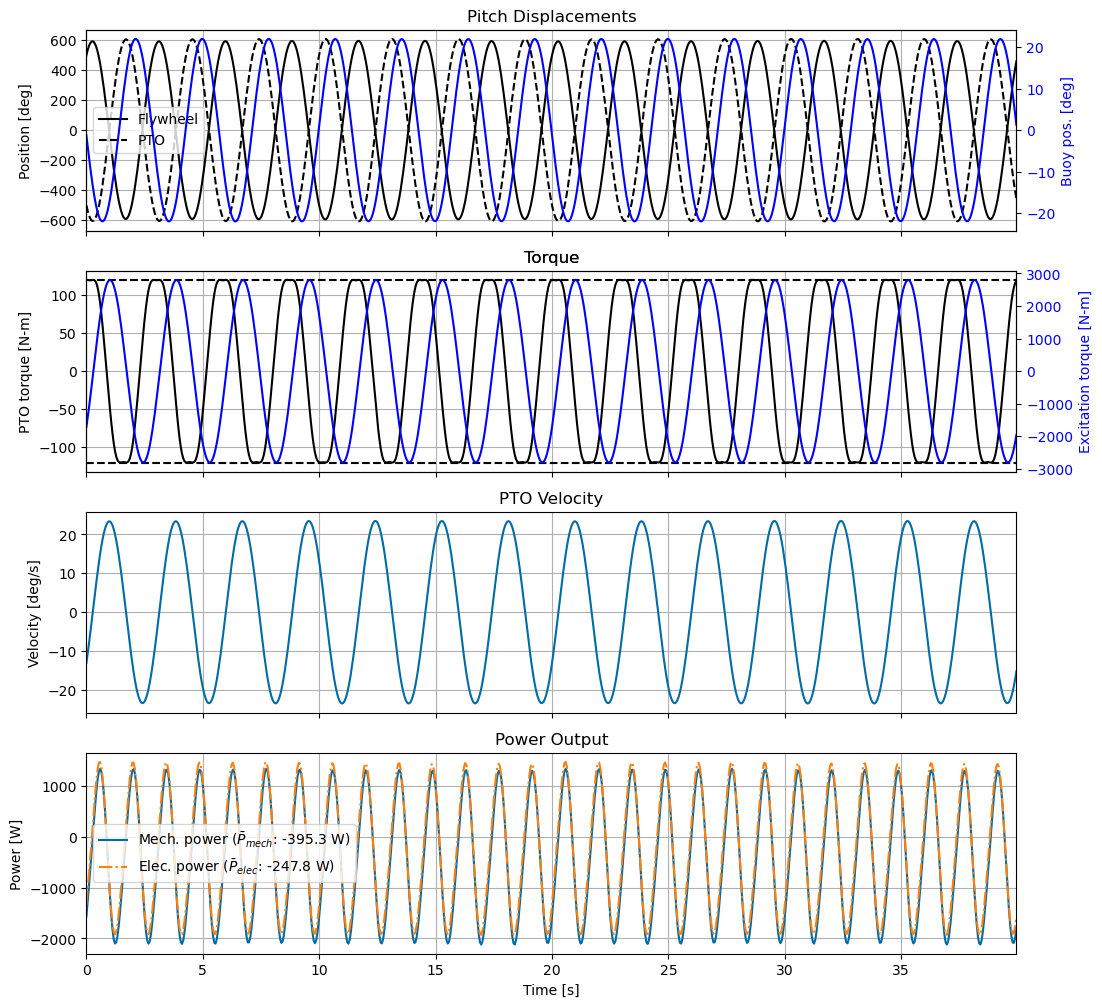

In [75]:
fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(12, 12))
t = wec_tdom.time.values

# Positions
ax[0].plot(t, fw_pos*180/np.pi, label='Flywheel', c='k')
ax[0].plot(t, pto_pos*180/np.pi, label='PTO', c='k', ls='--')
ax[0].set_title('Pitch Displacements')
ax[0].set_ylabel('Position [deg]')
ax[0].legend()

ax0 = ax[0].twinx()
ax0.tick_params(axis='y', labelcolor='b')
(wec_tdom.pos*180/np.pi).plot(hue='influenced_dof', label='Buoy', ax=ax0, c='b')
ax0.set_ylabel('Buoy pos. [deg]', color='b')
ax0.set_title('')

# Torques
ax[1].plot(t, pto_force, c='k')
ax[1].plot([t[0], t[-1]], [torque_peak_max, torque_peak_max], 'k--')
ax[1].plot([t[0], t[-1]], [-1*torque_peak_max, -1*torque_peak_max], 'k--')
ax[1].set_ylabel('PTO torque [N-m]')
ax[1].set_title('Torque')

ax1 = ax[1].twinx()
ax1.tick_params(axis='y', labelcolor='b')
wec_tdom['force'].sel(type=['Froude_Krylov', 'diffraction']).sum('type').plot(ax=ax1, c='b')
ax1.set_ylabel('Excitation torque [N-m]', color='b')
ax1.set_title('Torque')

# PTO Velocity
ax[2].plot(t, pto_vel)
ax[2].set_title('PTO Velocity')
ax[2].set_ylabel('Velocity [deg/s]')

# Power
ax[3].plot(t, pto_mech_power, label='Mech. power ($\\bar{P}_{mech}$: ' + f'{avg_mech_power:.1f} W)')
ax[3].plot(t, pto_elec_power, linestyle='dashdot', label='Elec. power ($\\bar{P}_{elec}$: ' + f'{avg_elec_power:.1f} W)')
ax[3].set_title('Power Output')
ax[3].set_ylabel('Power [W]')
ax[3].legend()
ax[3].set_xlabel('Time [s]')

for axi in ax:
    axi.grid()
    axi.label_outer()
    axi.autoscale(axis='x', tight=True)

### 2.3 Sankey Diagram

We use a Sankey diagram to visualize the average power flow from waves to electricity. On the very left is the theoretically possible optimal excitation. In order to reach this upper bound of exitation the WEC pitch velocity would need to be in phase with the pitch excitation force, in this case the radiated power is equal the amount of absorbed mechanical power. In practice, this will usually imply putting electrical power into the system (something we want to avoid!!!). 
With co-design, we are instead tapping the unused potential while limiting PTO losses and radiated power.

In [76]:
hydro_data = wot.add_linear_friction(bem_data, friction=None)    
hydro_data = wot.check_linear_damping(hydro_data, uniform_shift=False)    

Zi = wot.hydrodynamic_impedance(hydro_data)
Rad_res = np.real(Zi.squeeze())

Fex = wec_fdom.force.sel(type=['Froude_Krylov', 'diffraction']).sum('type')
Vel = wec_fdom.vel

P_max_absorbable = (np.abs(Fex)**2/(8*Rad_res) ).squeeze().sum('omega').item() # after Falnes Eq. 6.10
P_opt_excitation = 2*P_max_absorbable # after Falnes Eq. 6.10
P_radiated = ((1/2)*(Rad_res * np.abs(Vel)**2 ).squeeze().sum('omega').item()) # after Falnes Eq. 6.4
P_excited= (1/4)*(Fex*np.conjugate(Vel) + np.conjugate(Fex)*Vel ).squeeze().sum('omega').item() # after Falnes Eq. 6.3
P_absorbed = P_excited - P_radiated # after Falnes Eq. 6.2 absorbed by WEC-PTO (difference between actual excitation power and actual radiated power needs to be absorbed by PTO)

We also calculate the power dissipated due to flywheel friction and make sure that the absorbed power (calculated as the difference between excited and radiated power) matches the sum of mechanical power captured by the PTO and the power dissipated due to flywheel friction. We use a relative tolerance of 1%.

In [77]:
def fw_velocity(wec, x_wec, x_opt, waves, nsubsteps=1):
    pos_fw = wec.vec_to_dofmat(x_opt[nstate_pto:])
    vel_fw = np.dot(wec.derivative_mat, pos_fw)
    time_matrix = wec.time_mat_nsubsteps(nsubsteps)
    return np.dot(time_matrix, vel_fw)

def fw_friction_power(wec, x_wec, x_opt, waves, nsubsteps=1):
    force_td = f_friction(wec, x_wec, x_opt, waves, nsubsteps)
    vel_td = fw_velocity(wec, x_wec, x_opt, waves, nsubsteps)
    return vel_td * force_td

fw_fric_power = fw_friction_power(wec, x_wec, x_opt, waves_regular, nsubsteps)
avg_fw_fric_power = np.mean(fw_fric_power)

assert(np.isclose(P_absorbed, -1*(avg_mech_power -avg_fw_fric_power), rtol=0.01)) # assert that solver solution matches

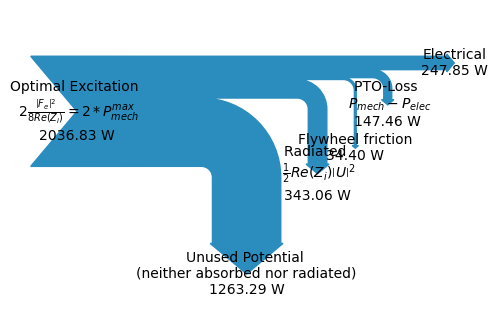

In [78]:
from matplotlib.sankey import Sankey

P_PTO_loss = avg_mech_power - avg_elec_power  
P_unused = P_opt_excitation - P_excited # Difference between the theoretical optimum excitation, if the WEC velocity would be in resonance with the excitation force

Power_flows = [P_opt_excitation, P_PTO_loss, -1*avg_fw_fric_power, -1*P_radiated, -1*P_unused, avg_elec_power, ]

fig = plt.figure(figsize = [6,4])
ax = fig.add_subplot(1, 1, 1,)
sankey = Sankey(ax=ax, 
                scale=0.5/P_max_absorbable,
                offset= 0,
                format = '%.2f W',shoulder = 0.02)

sankey.add(flows=Power_flows, 
           labels = ['Optimal Excitation \n $ 2 \\frac{\left | F_e \\right |^2}{8Re(Z_i)} = 2*P_{mech}^{max}$ ', 
                      'PTO-Loss \n $ P_{mech} - P_{elec}$', 
                      'Flywheel friction',
                      'Radiated \n $ \\frac{1}{2} Re(Z_i) \left | U \\right |^2  $ ', 
                      'Unused Potential \n(neither absorbed nor radiated)', 
                      'Electrical'], 
           orientations=[0, -1, -1,-1, -1, 0], # arrow directions
           pathlengths = [0.4,0.2,0.6,0.6,0.7,0.5,],
           trunklength = 1.5,
           edgecolor = '#2b8cbe',
           facecolor = '#2b8cbe' )

diagrams = sankey.finish()
for diagram in diagrams:
    for text in diagram.texts:
        text.set_fontsize(10);
plt.axis("off") 
plt.show()

## 3. Irregular wave
### 3.1 Solve
We will now run the same analysis for irregular waves. 

An interesting result is that due to the narrow banded resonance of the flywheel, the controller attempts to make the excitation force monochromatic with the resonant frequency. To achieve this it uses significant reactive power (power by the PTO into the system). This is still worth it, resulting in a larger average electrical power output. 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.40e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.38e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.37e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.35e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.11e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.10e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.08e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.07e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.06e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.89e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.81e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.73e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.65e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.57e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.30e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.24e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.18e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.12e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.06e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.10e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.05e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.00e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.96e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.91e-01.
This warning appears because the largest panel 

('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.87e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.82e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.78e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.73e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.69e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.99e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.96e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.92e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.89e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.85e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.35e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.34e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.32e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.31e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.29e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.06e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.05e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.04e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.03e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.02e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.57e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.49e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.41e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.33e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.26e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.06e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.00e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.88e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.82e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.91e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.87e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.82e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.78e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.73e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.03e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.99e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.96e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.92e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.89e-01.
This warning appears because the largest panel 

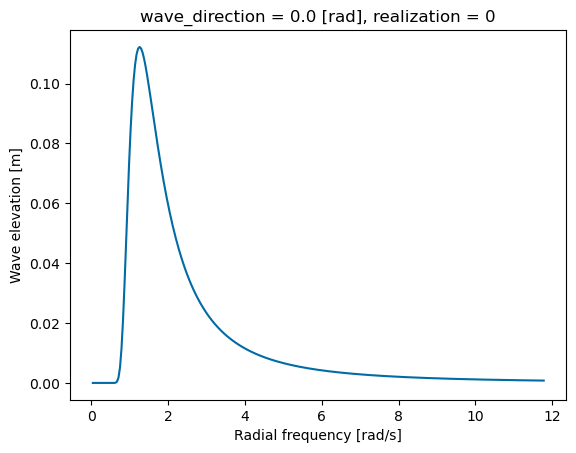

In [110]:
nfreq = 300
fend = 1.875

f1 = fend/nfreq
freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency
bem_data = wot.run_bem(pnr_fb, freq, rho=rho)
omega = bem_data.omega.values

nstate_pto = 2 * int(nfreq) # PTO forces
nstate_fw = 2 * int(nfreq)  # Flywheel positions
nstate_opt = nstate_pto + nstate_fw

# irregular
Hs = 1.5
Tp = 5 

fp = 1/Tp
spectrum = lambda f: wot.waves.pierson_moskowitz_spectrum(f, fp, Hs)
efth = wot.waves.omnidirectional_spectrum(f1, nfreq, spectrum, "Pierson-Moskowitz")
waves_irregular = wot.waves.long_crested_wave(efth, nrealizations = 1)

fig, ax = plt.subplots()
plt1 = np.abs(waves_irregular.sel(realization=0)).plot(
    ax=ax, color='C0')

In [111]:
z_11 = np.array([[np.zeros(omega.shape)]])
off_diag = np.sqrt(3.0/2.0) * torque_constant
z_12 = np.array([[-1*(off_diag+0j) * np.ones(omega.shape)]])
z_21 = np.array([[-1*(off_diag+0j) * np.ones(omega.shape)]])
z_22 = np.array([[winding_resistance * np.ones(omega.shape)]])

z_12_inv = np.linalg.inv(z_12.T).T
mmult = lambda a,b: np.einsum('mnr,mnr->mnr', a, b)
abcd_11 = -1 * mmult(z_12_inv, z_11)
abcd_12 = z_12_inv
abcd_21 = z_21 - mmult(z_22, mmult(z_12_inv, z_11))
abcd_22 = mmult(z_22, z_12_inv)
row_1 = np.hstack([abcd_11, abcd_12])
row_2 = np.hstack([abcd_21, abcd_22])
abcd = np.vstack([row_1, row_2])

for idof in range(2):
    for jdof in range(2):
        Zp = abcd[idof, jdof, :]
        re = np.real(Zp)
        im = np.imag(Zp)
        blocks = [np.array([[ire, iim], [iim, ire]])
                           for (ire, iim) in zip(re[:-1], im[:-1])]
        blocks = [re[0]] + blocks + [re[-1]]
        if jdof==0:
            row = block_diag(*blocks)
        else:
            row = np.hstack([row, block_diag(*blocks)])
    if idof==0:
        transfer_mat = row
    else:
        transfer_mat = np.vstack([transfer_mat, row])

wec = wot.WEC.from_bem(bem_data,
                       f_add=f_add,
                       constraints=constraints,
                       uniform_shift=False,
                       dof_names=bem_data.influenced_dof.values,)

obj_fun = average_electrical_power
results = wec.solve(
    waves_irregular,
    obj_fun,
    nstate_opt,
    scale_x_wec=1e1,
    scale_x_opt=1e-2,
    scale_obj=1e-2,
)
power_results = [result.fun for result in results]
print(f'Optimal average power: {np.mean(power_results):.2f} W')

C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.722211118236512
            Iterations: 20
            Function evaluations: 21
            Gradient evaluations: 20
Optimal average power: -972.22 W


The solver is run 5 times (1 for each wave phase realization). Each of these phase realizations leads to a slightly different result for optimal average power. Thus, for irregular wave conditions, it is recommended to average the optimal average power result over multiple phase realizations. The number of phase realizations required is further discussed at the bottom of this notebook.

### 3.2 Post-process and plot

In [112]:
nsubsteps = 5
wec_fdom, wec_tdom = wec.post_process(results[0], waves_irregular.sel(realization=0), nsubsteps=nsubsteps)

# Manually post-process PTO and flywheel outputs
x_wec, x_opt = wot.decompose_state(results[0].x, 1, nfreq)
fw_pos = np.dot(wec.time_mat_nsubsteps(nsubsteps), x_opt[nstate_pto:])
pto_pos = rel_position(wec, x_wec, x_opt, waves_irregular.sel(realization=0), nsubsteps)
pto_vel = rel_velocity(wec, x_wec, x_opt, waves_irregular.sel(realization=0), nsubsteps)
pto_force = f_motor(wec, x_wec, x_opt, waves_irregular.sel(realization=0), nsubsteps)
pto_force_fd = wec.td_to_fd(pto_force[::nsubsteps])
pto_mech_power = mechanical_power(wec, x_wec, x_opt, waves_irregular.sel(realization=0), nsubsteps)
pto_elec_power = electrical_power(wec, x_wec, x_opt, waves_irregular.sel(realization=0), nsubsteps)
avg_mech_power = np.mean(pto_mech_power)
avg_elec_power = np.mean(pto_elec_power)

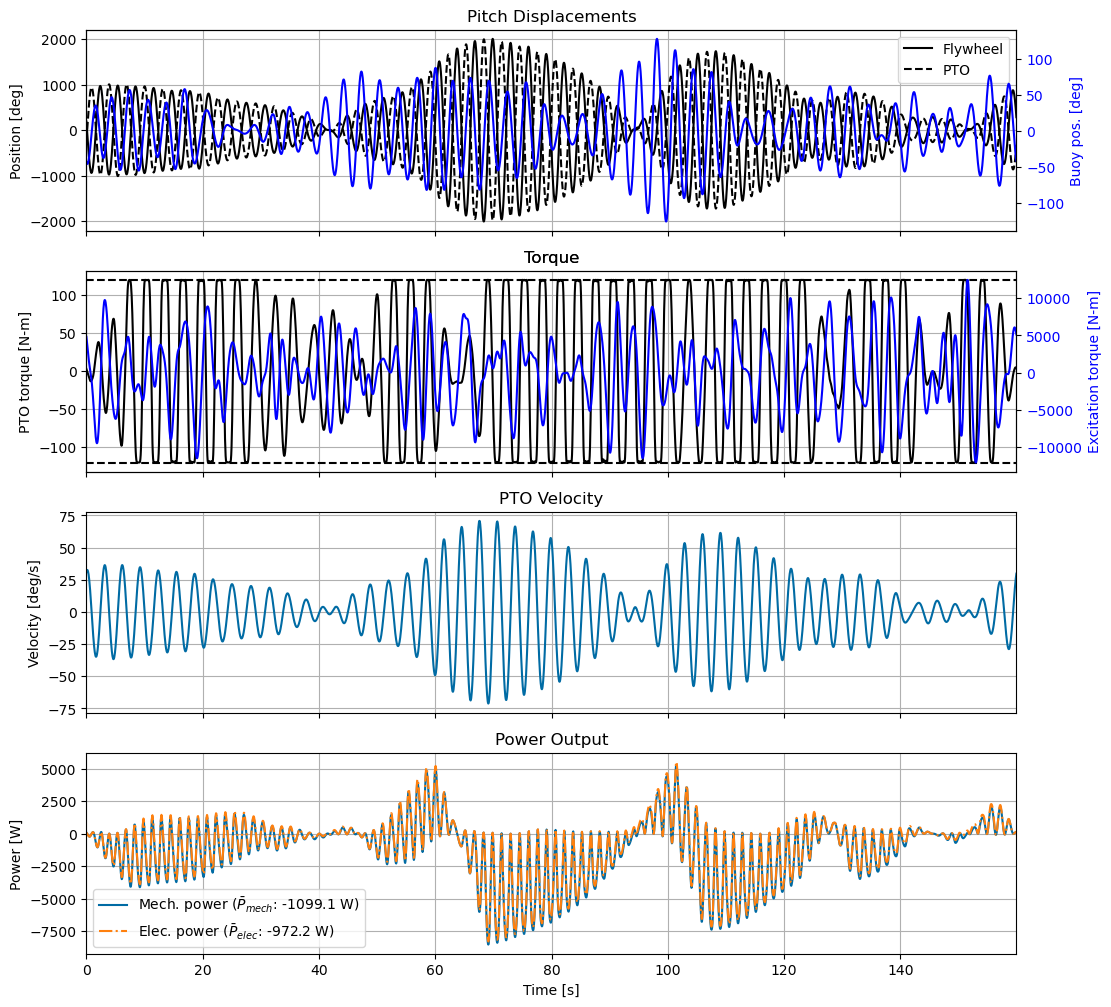

In [113]:
fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(12, 12))
t = wec_tdom.time.values

# Positions
ax[0].plot(t, fw_pos*180/np.pi, label='Flywheel', c='k')
ax[0].plot(t, pto_pos*180/np.pi, label='PTO', c='k', ls='--')
ax[0].set_title('Pitch Displacements')
ax[0].set_ylabel('Position [deg]')
ax[0].legend()

ax0 = ax[0].twinx()
ax0.tick_params(axis='y', labelcolor='b')
(wec_tdom.pos*180/np.pi).plot(hue='influenced_dof', label='Buoy', ax=ax0, c='b')
ax0.set_ylabel('Buoy pos. [deg]', color='b')
ax0.set_title('')

# Torques
ax[1].plot(t, pto_force, c='k')
ax[1].plot([t[0], t[-1]], [torque_peak_max, torque_peak_max], 'k--')
ax[1].plot([t[0], t[-1]], [-1*torque_peak_max, -1*torque_peak_max], 'k--')
ax[1].set_ylabel('PTO torque [N-m]')
ax[1].set_title('Torque')

ax1 = ax[1].twinx()
ax1.tick_params(axis='y', labelcolor='b')
wec_tdom['force'].sel(type=['Froude_Krylov', 'diffraction']).sum('type').plot(ax=ax1, c='b')
ax1.set_ylabel('Excitation torque [N-m]', color='b')
ax1.set_title('Torque')

# PTO Velocity
ax[2].plot(t, pto_vel)
ax[2].set_title('PTO Velocity')
ax[2].set_ylabel('Velocity [deg/s]')

# Power
ax[3].plot(t, pto_mech_power, label='Mech. power ($\\bar{P}_{mech}$: ' + f'{avg_mech_power:.1f} W)')
ax[3].plot(t, pto_elec_power, linestyle='dashdot', label='Elec. power ($\\bar{P}_{elec}$: ' + f'{avg_elec_power:.1f} W)')
ax[3].set_title('Power Output')
ax[3].set_ylabel('Power [W]')
ax[3].legend()
ax[3].set_xlabel('Time [s]')

for axi in ax:
    axi.grid()
    axi.label_outer()
    axi.autoscale(axis='x', tight=True)

Text(0.5, 0, 'frequency [rad/s]')

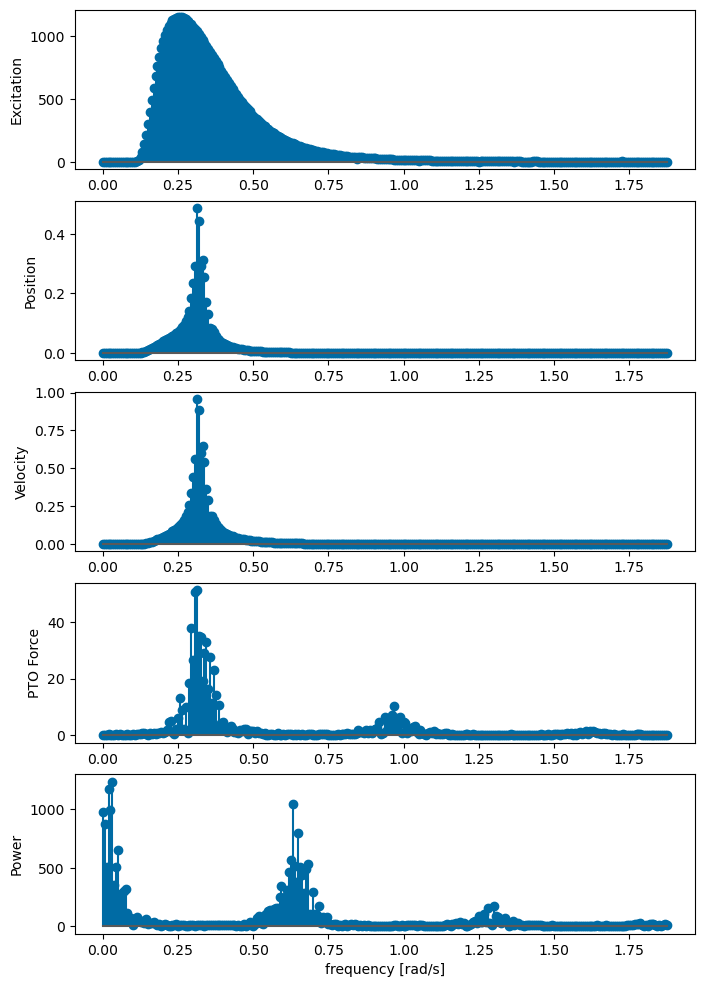

In [114]:
excitation_force = wec_fdom['force'].sel(type='Froude_Krylov') + wec_fdom['force'].sel(type='diffraction')
position = wec_fdom.pos
velocity = wec_fdom.vel
pto_force =  pto_force_fd
mech_power = wec.td_to_fd(pto_mech_power[::nsubsteps])
power = wec.td_to_fd(pto_elec_power[::nsubsteps])

fig, ax = plt.subplots(5,1,figsize=(8, 12))

ax[0].stem(wec_fdom['freq'],abs(excitation_force))
ax[0].set_ylabel('Excitation')

ax[1].stem(wec_fdom['freq'],abs(position))
ax[1].set_ylabel('Position')

ax[2].stem(wec_fdom['freq'],abs(velocity))
ax[2].set_ylabel('Velocity')

# Plot PTO force
ax[3].stem(wec_fdom['freq'],abs(pto_force))
ax[3].set_ylabel('PTO Force')

# Plot power
#ax[5].stem(omegas,abs(mech_power))
ax[4].stem(wec_fdom['freq'],abs(power))
ax[4].set_ylabel('Power')
ax[4].set_xlabel('frequency [rad/s]')

Next, we want to demonstrate why it is recommended to test multiple phase realizations instead of testing a longer simulation time.

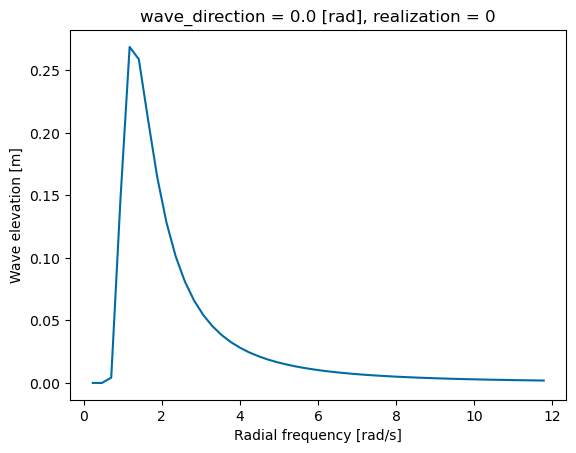

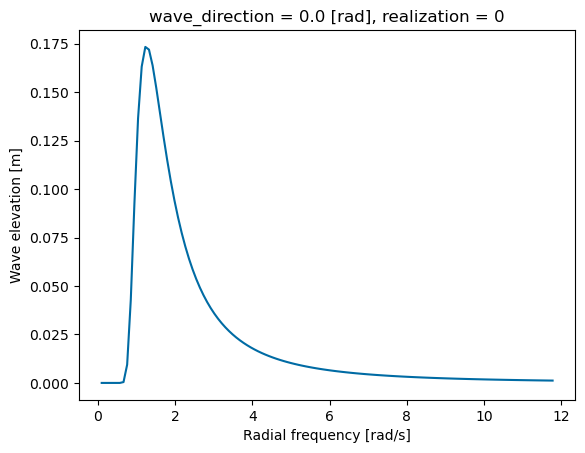

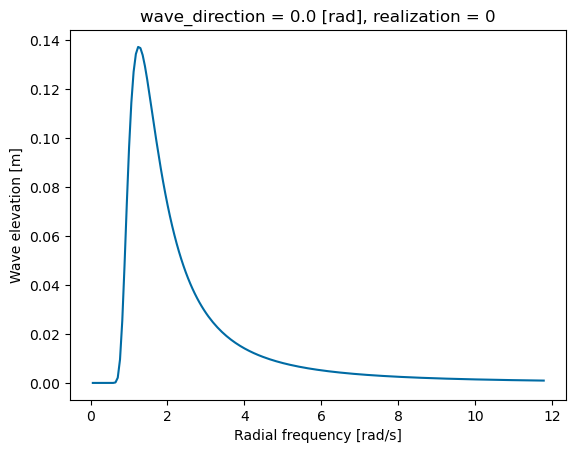

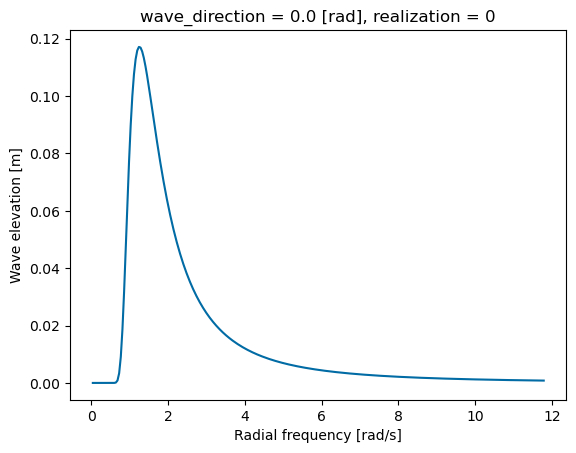

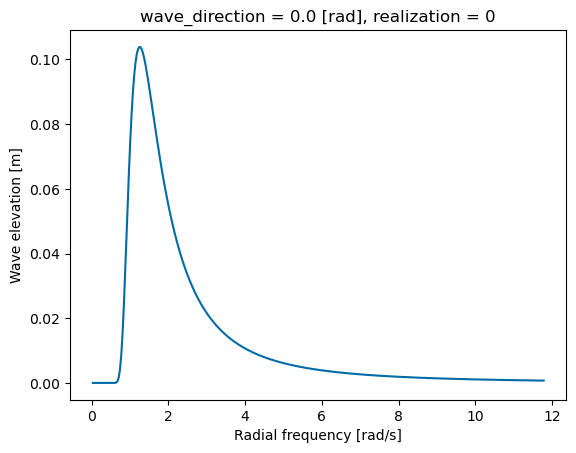

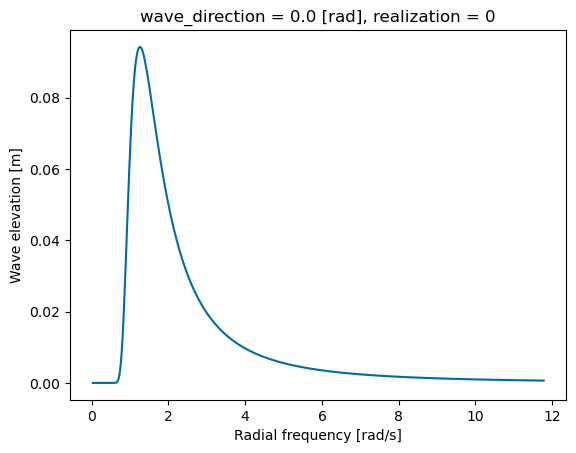

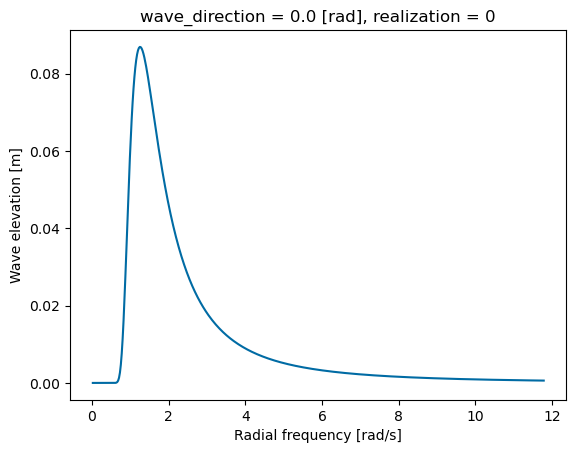

In [24]:
nfreqs = np.linspace(50,200,7)
fend = 1.875

for nfreq in nfreqs:
    
#    if nfreq >= 30:
#        scale_x_wec=1e1
#        scale_x_opt=1e-2
#        scale_obj=1e-2
    
    f1 = fend/nfreq
    freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency

    efth = wot.waves.omnidirectional_spectrum(f1, int(nfreq), spectrum, "Pierson-Moskowitz")
    waves_irregular = wot.waves.long_crested_wave(efth, nrealizations = 1)

    

    fig, ax = plt.subplots()
    plt1 = np.abs(waves_irregular.sel(realization=0)).plot(
        ax=ax, color='C0')

In [51]:
import time

# compare run times vs. number of frequencies
nfreqs = np.linspace(50,300,11)
print(nfreqs)
fend = 1.875

runtime = []
meanpower = []
Pmaxs = []

fp = 1/Tp
spectrum = lambda f: wot.waves.pierson_moskowitz_spectrum(f, fp, Hs)

minutes_needed = 20

for nfreq in nfreqs:
    
#    if nfreq >= 30:
#        scale_x_wec=1e1
#        scale_x_opt=1e-2
#        scale_obj=1e-2
    
    f1 = fend/nfreq
    freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency
    bem_data = wot.run_bem(pnr_fb, freq, rho=rho)
    omega = bem_data.omega.values
    
    nstate_pto = 2 * int(nfreq) # PTO forces
    nstate_fw = 2 * int(nfreq)  # Flywheel positions
    nstate_opt = nstate_pto + nstate_fw

    sim_time = (1/(fend/nfreq))
    nrealizations_needed = minutes_needed*60/sim_time
    nrealizations_needed = np.round(nrealizations_needed)
    
    def x_rel(wec, x_wec, x_opt):
        pos_wec = wec.vec_to_dofmat(x_wec)
        pos_fw = wec.vec_to_dofmat(x_opt[nstate_pto:])
        return pos_wec - pos_fw

    def rel_position(wec, x_wec, x_opt, waves, nsubsteps=1):
        pos_rel = x_rel(wec, x_wec, x_opt)
        time_matrix = wec.time_mat_nsubsteps(nsubsteps)
        return np.dot(time_matrix, pos_rel)

    def rel_velocity(wec, x_wec, x_opt, waves, nsubsteps=1):
        pos_rel = x_rel(wec, x_wec, x_opt)
        vel_rel = np.dot(wec.derivative_mat, pos_rel)
        time_matrix = wec.time_mat_nsubsteps(nsubsteps)
        return np.dot(time_matrix, vel_rel)
    
    def f_motor(wec, x_wec, x_opt, waves, nsubsteps=1):
        motor = np.reshape(x_opt[:nstate_pto], (-1, ndof), order='F')
        time_matrix = wec.time_mat_nsubsteps(nsubsteps)
        return np.dot(time_matrix, motor)
    
    torque_constant = 3.512
    winding_resistance = 0.304

    z_11 = np.array([[np.zeros(omega.shape)]])
    off_diag = np.sqrt(3.0/2.0) * torque_constant
    z_12 = np.array([[-1*(off_diag+0j) * np.ones(omega.shape)]])
    z_21 = np.array([[-1*(off_diag+0j) * np.ones(omega.shape)]])
    z_22 = np.array([[winding_resistance * np.ones(omega.shape)]])
    
    z_12_inv = np.linalg.inv(z_12.T).T
    mmult = lambda a,b: np.einsum('mnr,mnr->mnr', a, b)
    abcd_11 = -1 * mmult(z_12_inv, z_11)
    abcd_12 = z_12_inv
    abcd_21 = z_21 - mmult(z_22, mmult(z_12_inv, z_11))
    abcd_22 = mmult(z_22, z_12_inv)
    row_1 = np.hstack([abcd_11, abcd_12])
    row_2 = np.hstack([abcd_21, abcd_22])
    abcd = np.vstack([row_1, row_2])

    for idof in range(2):
        for jdof in range(2):
            Zp = abcd[idof, jdof, :]
            re = np.real(Zp)
            im = np.imag(Zp)
            blocks = [np.array([[ire, iim], [iim, ire]])
                               for (ire, iim) in zip(re[:-1], im[:-1])]
            blocks = [re[0]] + blocks + [re[-1]]
            if jdof==0:
                row = block_diag(*blocks)
            else:
                row = np.hstack([row, block_diag(*blocks)])
        if idof==0:
            transfer_mat = row
        else:
            transfer_mat = np.vstack([transfer_mat, row])
    
    def mechanical_power(wec, x_wec, x_opt, waves, nsubsteps=1):
        force_td = f_motor(wec, x_wec, x_opt, waves, nsubsteps)
        vel_td = rel_velocity(wec, x_wec, x_opt, waves, nsubsteps)
        return vel_td * force_td

    def electrical_power(wec, x_wec, x_opt, waves, nsubsteps=1):
        q1_td = rel_velocity(wec, x_wec, x_opt, waves)
        e1_td = f_motor(wec, x_wec, x_opt, waves)
        q1 = wot.complex_to_real(wec.td_to_fd(q1_td, False))
        e1 = wot.complex_to_real(wec.td_to_fd(e1_td, False))
        vars_1 = np.hstack([q1, e1])
        vars_1_flat = wec.dofmat_to_vec(vars_1)
        vars_2_flat = np.dot(transfer_mat, vars_1_flat)
        vars_2 = wot.vec_to_dofmat(vars_2_flat, 2)
        q2 = vars_2[:, 0]
        e2 = vars_2[:, 1]
        time_mat = wec.time_mat_nsubsteps(nsubsteps)
        q2_td = np.dot(time_mat, q2)
        e2_td = np.dot(time_mat, e2)
        return q2_td * e2_td

    def energy(wec, x_wec, x_opt, waves, nsubsteps=1):
        power_td = electrical_power(wec, x_wec, x_opt, waves, nsubsteps)
        return np.sum(power_td) * wec.dt/nsubsteps

    def average_electrical_power(wec, x_wec, x_opt, waves, nsubsteps=1):
        e = energy(wec, x_wec, x_opt, waves, nsubsteps)
        return e / wec.tf
    
    torque_peak_max = 120.
    def const_peak_torque_pto(wec, x_wec, x_opt, waves, nsubsteps=5):
        torque = f_motor(wec, x_wec, x_opt, waves, nsubsteps)
        return torque_peak_max - np.abs(torque.flatten())

    def f_friction(wec, x_wec, x_opt, waves, nsubsteps=1):
        rel_vel = rel_velocity(wec, x_wec, x_opt, waves, nsubsteps)
        return -1 * (
            np.tanh(rel_vel) * flywheel_props['Coulomb friction']
          + rel_vel * flywheel_props['Viscous friction']
        )

    def f_spring(wec, x_wec, x_opt, waves, nsubsteps=1):
        pos = rel_position(wec, x_wec, x_opt, waves, nsubsteps) / (flywheel_props['Gear ratio']**2)
        spring_force = -k_spring  * pos
        return spring_force

    def fw_inertia(wec, x_wec, x_opt, waves, nsubsteps=1):
        pos_fw = wec.vec_to_dofmat(x_opt[nstate_pto:])
        acc_fw = np.dot(wec.derivative2_mat, pos_fw)
        time_matrix = wec.time_mat_nsubsteps(nsubsteps)
        acc_fw = np.dot(time_matrix, acc_fw)
        return flywheel_props['MOI'] * acc_fw

    def const_flywheel_resid(wec, x_wec, x_opt, waves):
        return (fw_inertia(wec, x_wec, x_opt, waves)
              + f_spring(wec, x_wec, x_opt, waves)
              + f_friction(wec, x_wec, x_opt, waves)
              + f_motor(wec, x_wec, x_opt, waves)
              ).flatten()

    f_add = {
        'Motor': f_motor,
        'Friction': f_friction,
        'Spring': f_spring,   
    }

    constraints = [
        {'type': 'ineq', 'fun': const_peak_torque_pto},
        {'type': 'eq', 'fun': const_flywheel_resid},
    ]
    
    wec = wot.WEC.from_bem(bem_data,
                           f_add=f_add,
                           constraints=constraints,
                           uniform_shift=False,
                           dof_names=bem_data.influenced_dof.values,)

    efth = wot.waves.omnidirectional_spectrum(f1, int(nfreq), spectrum, "Pierson-Moskowitz")
    waves_irregular = wot.waves.long_crested_wave(efth, nrealizations = int(nrealizations_needed))
    
    print(f'nfreq: {nfreq}')
    starttime = time.time()
    
    results = wec.solve(
        waves_irregular,
        obj_fun,
        nstate_opt=nstate_opt,
        scale_x_wec=1e1,
        scale_x_opt=1e-2,
        scale_obj=1e-2,
    )
    
    power_results = [result.fun for result in results]
    x_results = [result.x for result in results]
    print(f'Optimal average power: {np.mean(power_results):.2f} W')
    
    meanpower.append(np.mean(power_results))
    
    endtime = time.time()
    runtime.append(endtime-starttime)
    print(runtime)
    
    # calculate max power
    Fe = bem_data['Froude_Krylov_force'] + bem_data['diffraction_force']
    ampSpect = waves_irregular.sel(realization=0).values
    Fe = np.squeeze(ampSpect)*np.squeeze(Fe.values)

    hydro_data = wot.add_linear_friction(bem_data)
    Zi = wot.hydrodynamic_impedance(hydro_data)

    # Maximum Mechanical Power
    P_ub_vec = (1/8)*abs(Fe)**2/np.real(Zi.squeeze())
    P_ub = - sum(np.squeeze(P_ub_vec)).values
    
    Pmaxs.append(P_ub)

print(meanpower)
print(runtime)
print(Pmaxs)

import xarray as xr

res_ds = xr.Dataset(data_vars = dict(power=(['ind'],meanpower),time=(['ind'],runtime),pmax=(['ind'],Pmaxs)), 
                    coords=dict(ind=range(len(meanpower))))
res_ds.to_netcdf('pioneer_freq_time.nc')

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.32e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.23e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.16e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.08e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.44e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.32e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.23e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.16e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.62e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.44e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.


[ 50.  75. 100. 125. 150. 175. 200. 225. 250. 275. 300.]
('Pitch', 'Pitch')


nfreq: 50.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8.083384172349225
            Iterations: 13
            Function evaluations: 14
            Gradient evaluations: 13
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8.320019516707465
            Iterations: 12
            Function evaluations: 13
            Gradient evaluations: 12
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8.116499914053556
            Iterations: 13
            Function evaluations: 14
            Gradient evaluations: 13
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8.363264906653056
            Iterations: 12
            Function evaluations: 13
            Gradient evaluations: 12
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8.163955868546568
            Iterations: 12
            

Optimization terminated successfully    (Exit mode 0)
            Current function value: -8.093521405021363
            Iterations: 13
            Function evaluations: 14
            Gradient evaluations: 13
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8.277723892415388
            Iterations: 13
            Function evaluations: 14
            Gradient evaluations: 13
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8.059534641679837
            Iterations: 12
            Function evaluations: 13
            Gradient evaluations: 12
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8.38221810985368
            Iterations: 11
            Function evaluations: 12
            Gradient evaluations: 11
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8.234806493624706
            Iterations: 14
            Function eval

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.35e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.29e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.23e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.18e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.10e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.91e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.73e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.56e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.40e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.24e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.89e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.57e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.26e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.56e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.44e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.


('Pitch', 'Pitch')


nfreq: 75.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8.4523268129106
            Iterations: 15
            Function evaluations: 16
            Gradient evaluations: 15
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8.579626034341384
            Iterations: 14
            Function evaluations: 15
            Gradient evaluations: 14
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8.13390604630964
            Iterations: 14
            Function evaluations: 15
            Gradient evaluations: 14
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8.202654446545209
            Iterations: 14
            Function evaluations: 15
            Gradient evaluations: 14
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8.600106121309297
            Iterations: 14
            Fun

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.37e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.32e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.28e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.23e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.30e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.12e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.77e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.60e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.44e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.37e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.32e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.28e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.49e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.30e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.12e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.77e-01.
This warning appears because the largest panel 

('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.72e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.62e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.53e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.44e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.


nfreq: 100.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: -10.200355371084235
            Iterations: 17
            Function evaluations: 18
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: -10.425574311465317
            Iterations: 17
            Function evaluations: 18
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: -10.099238895731897
            Iterations: 18
            Function evaluations: 19
            Gradient evaluations: 18
Optimization terminated successfully    (Exit mode 0)
            Current function value: -10.297898338172931
            Iterations: 18
            Function evaluations: 19
            Gradient evaluations: 18
Optimization terminated successfully    (Exit mode 0)
            Current function value: -10.050003465580627
            Iterations: 18
      

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.38e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.34e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.30e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.27e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.20e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.02e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.85e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.69e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.53e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.34e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.25e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.16e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.07e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.98e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.08e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.06e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.03e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.01e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.83e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.67e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.54e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.42e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.29e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.18e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.51e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.44e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.


('Pitch', 'Pitch')


nfreq: 125.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: -10.45275900743144
            Iterations: 17
            Function evaluations: 18
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: -10.292854815146502
            Iterations: 17
            Function evaluations: 18
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: -10.644462833230428
            Iterations: 17
            Function evaluations: 18
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: -10.566589445515646
            Iterations: 18
            Function evaluations: 19
            Gradient evaluations: 18
Optimization terminated successfully    (Exit mode 0)
            Current function value: -10.51691977320057
            Iterations: 19
        

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.38e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.35e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.32e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.29e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.89e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.73e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.57e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.41e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.26e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.10e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.00e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.91e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.82e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.73e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.44e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.


('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.38e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.35e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.32e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.29e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.26e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.73e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.57e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.41e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.26e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.11e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.00e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.91e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.82e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.73e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.65e-01.
This warning appears because the largest panel 

nfreq: 150.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.690935225258166
            Iterations: 18
            Function evaluations: 19
            Gradient evaluations: 18
Optimization terminated successfully    (Exit mode 0)
            Current function value: -10.319762561345838
            Iterations: 17
            Function evaluations: 18
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: -10.12185058463978
            Iterations: 18
            Function evaluations: 19
            Gradient evaluations: 18
Optimization terminated successfully    (Exit mode 0)
            Current function value: -10.11901382431032
            Iterations: 17
            Function evaluations: 18
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: -10.113466431780184
            Iterations: 17
         

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.39e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.36e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.33e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.31e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.44e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.29e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.14e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.99e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.85e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.75e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.65e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.56e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.47e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.38e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.06e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.00e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.94e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.


('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.88e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.82e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.76e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.71e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.65e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.10e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.08e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.07e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.05e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.03e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.69e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.57e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.46e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.35e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.25e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.66e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.59e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.52e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.45e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.38e-01.
This warning appears because the largest panel 

nfreq: 175.0


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.706798795950965
            Iterations: 18
            Function evaluations: 19
            Gradient evaluations: 18


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -10.001690409988926
            Iterations: 16
            Function evaluations: 17
            Gradient evaluations: 16


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.131438242501085
            Iterations: 18
            Function evaluations: 19
            Gradient evaluations: 18


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.900233851217234
            Iterations: 18
            Function evaluations: 19
            Gradient evaluations: 18


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.449994130924102
            Iterations: 17
            Function evaluations: 18
            Gradient evaluations: 17


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.969130170752889
            Iterations: 17
            Function evaluations: 18
            Gradient evaluations: 17


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -10.089405061001386
            Iterations: 16
            Function evaluations: 17
            Gradient evaluations: 16


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.730858642482213
            Iterations: 18
            Function evaluations: 19
            Gradient evaluations: 18


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.716122842186541
            Iterations: 17
            Function evaluations: 18
            Gradient evaluations: 17


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.580975928653624
            Iterations: 18
            Function evaluations: 19
            Gradient evaluations: 18


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.932187991369162
            Iterations: 16
            Function evaluations: 17
            Gradient evaluations: 16


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -10.182711051103736
            Iterations: 17
            Function evaluations: 18
            Gradient evaluations: 17


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.786229114308417
            Iterations: 17
            Function evaluations: 18
            Gradient evaluations: 17
Optimal average power: -978.29 W
[386.27643299102783, 613.8799395561218, 1359.1934950351715, 1861.9326510429382, 2715.09477353096, 6187.5001010894775]


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.39e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.37e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.34e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.32e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.89e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.75e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.60e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.46e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.33e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.30e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.21e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.12e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.03e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel 

('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.60e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.52e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.45e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.37e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.29e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.13e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.08e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.03e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.97e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.92e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.25e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.23e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.21e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.19e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.17e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.94e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.81e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.69e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.57e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.45e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.69e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.60e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.52e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.45e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.37e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.19e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.13e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.08e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.03e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.97e-01.
This warning appears because the largest panel 

nfreq: 200.0


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.329998702393395
            Iterations: 19
            Function evaluations: 20
            Gradient evaluations: 19


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.611813901001126
            Iterations: 19
            Function evaluations: 20
            Gradient evaluations: 19


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.927718531152012
            Iterations: 18
            Function evaluations: 19
            Gradient evaluations: 18


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.803596500087949
            Iterations: 17
            Function evaluations: 18
            Gradient evaluations: 17


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.752910338113546
            Iterations: 17
            Function evaluations: 18
            Gradient evaluations: 17


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.628776586622573
            Iterations: 18
            Function evaluations: 19
            Gradient evaluations: 18


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.5303426231886
            Iterations: 18
            Function evaluations: 19
            Gradient evaluations: 18


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.618729033836185
            Iterations: 19
            Function evaluations: 20
            Gradient evaluations: 19


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.968647553605521
            Iterations: 17
            Function evaluations: 18
            Gradient evaluations: 17


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -10.081266937735162
            Iterations: 18
            Function evaluations: 19
            Gradient evaluations: 18


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -10.02585863723208
            Iterations: 18
            Function evaluations: 19
            Gradient evaluations: 18
Optimal average power: -975.27 W
[386.27643299102783, 613.8799395561218, 1359.1934950351715, 1861.9326510429382, 2715.09477353096, 6187.5001010894775, 9215.623301029205]


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.39e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.37e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.35e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.33e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.03e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.01e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.99e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.86e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.73e-01.
This warning appears because the largest panel 

('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.16e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.06e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.87e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.78e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.36e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.29e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.23e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.16e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.10e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.10e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.05e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.00e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.96e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.91e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.29e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.27e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.25e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.23e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.22e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.48e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.36e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.24e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.12e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.01e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.26e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.18e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.10e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.02e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.73e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.68e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.62e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.56e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.51e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.65e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.60e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.56e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.52e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.48e-01.
This warning appears because the largest panel 

nfreq: 225.0


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -10.062312752819892
            Iterations: 20
            Function evaluations: 21
            Gradient evaluations: 20


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.86789148887337
            Iterations: 19
            Function evaluations: 20
            Gradient evaluations: 19


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.927403347536822
            Iterations: 19
            Function evaluations: 20
            Gradient evaluations: 19


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.620870349156391
            Iterations: 20
            Function evaluations: 21
            Gradient evaluations: 20


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.961331842408084
            Iterations: 20
            Function evaluations: 21
            Gradient evaluations: 20


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.844003980797174
            Iterations: 18
            Function evaluations: 19
            Gradient evaluations: 18


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.653744354313355
            Iterations: 18
            Function evaluations: 19
            Gradient evaluations: 18


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.945817765438276
            Iterations: 20
            Function evaluations: 21
            Gradient evaluations: 20


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -10.033014198949012
            Iterations: 20
            Function evaluations: 21
            Gradient evaluations: 20


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.813925974712667
            Iterations: 20
            Function evaluations: 21
            Gradient evaluations: 20
Optimal average power: -987.30 W
[386.27643299102783, 613.8799395561218, 1359.1934950351715, 1861.9326510429382, 2715.09477353096, 6187.5001010894775, 9215.623301029205, 14775.067338466644]


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.40e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.38e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.36e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.34e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.06e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.04e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.03e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.02e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.01e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.20e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.11e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.02e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.94e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.85e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.54e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.48e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.42e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.35e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.29e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.34e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.29e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.25e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.


('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.20e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.16e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.11e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.07e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.03e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.38e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.36e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.34e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.32e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.30e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.03e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.02e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.01e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.95e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.83e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.02e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.94e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.85e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.77e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.69e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.42e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.35e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.29e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.23e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.18e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.25e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.20e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.16e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.11e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.07e-01.
This warning appears because the largest panel 

nfreq: 250.0


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -10.062546431958996
            Iterations: 20
            Function evaluations: 21
            Gradient evaluations: 20


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.90737913056101
            Iterations: 19
            Function evaluations: 20
            Gradient evaluations: 19


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.956600328543786
            Iterations: 21
            Function evaluations: 22
            Gradient evaluations: 21


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -10.027872579955837
            Iterations: 21
            Function evaluations: 22
            Gradient evaluations: 21


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -10.078574135363889
            Iterations: 19
            Function evaluations: 20
            Gradient evaluations: 19


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -10.033289663923393
            Iterations: 19
            Function evaluations: 20
            Gradient evaluations: 19


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -10.161350107471982
            Iterations: 21
            Function evaluations: 22
            Gradient evaluations: 21


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -10.080796292254483
            Iterations: 20
            Function evaluations: 21
            Gradient evaluations: 20


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.977520343599696
            Iterations: 19
            Function evaluations: 20
            Gradient evaluations: 19
Optimal average power: -1003.18 W
[386.27643299102783, 613.8799395561218, 1359.1934950351715, 1861.9326510429382, 2715.09477353096, 6187.5001010894775, 9215.623301029205, 14775.067338466644, 23147.317128419876]


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.40e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.38e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.36e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.35e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.08e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.07e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.06e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.05e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.04e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.57e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.48e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.40e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.31e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.23e-01.
This warning appears because the largest panel 

('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.00e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.88e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.81e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.75e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.78e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.73e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.69e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.64e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.60e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.86e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.82e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.78e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.75e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.71e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.26e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.25e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.23e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.22e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.20e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.81e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.71e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.60e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.50e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.40e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.84e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.76e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.69e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.62e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.54e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.40e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.35e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.29e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.24e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.19e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.33e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.29e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.25e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.21e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.17e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.51e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.47e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.44e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.


nfreq: 275.0


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.956114562442668
            Iterations: 19
            Function evaluations: 20
            Gradient evaluations: 19


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -10.027329864413087
            Iterations: 18
            Function evaluations: 19
            Gradient evaluations: 18


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.805662059017374
            Iterations: 18
            Function evaluations: 19
            Gradient evaluations: 18


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.853521479415765
            Iterations: 19
            Function evaluations: 20
            Gradient evaluations: 19


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -10.068357910289496
            Iterations: 19
            Function evaluations: 20
            Gradient evaluations: 19


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.854487411013144
            Iterations: 19
            Function evaluations: 20
            Gradient evaluations: 19


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.900045665820207
            Iterations: 19
            Function evaluations: 20
            Gradient evaluations: 19


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -10.116185512045012
            Iterations: 19
            Function evaluations: 20
            Gradient evaluations: 19
Optimal average power: -994.77 W
[386.27643299102783, 613.8799395561218, 1359.1934950351715, 1861.9326510429382, 2715.09477353096, 6187.5001010894775, 9215.623301029205, 14775.067338466644, 23147.317128419876, 31146.037093400955]


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.40e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.38e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.37e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.35e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.11e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.10e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.08e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.07e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.06e+00.
This warning appears because the largest panel 

('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.98e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.89e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.81e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.73e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.65e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.36e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.30e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.24e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.18e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.12e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.15e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.10e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.05e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.00e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.96e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.21e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.17e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.13e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.10e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.06e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.47e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.44e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.40e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.38e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.13e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.12e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.11e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.10e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.08e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.06e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.98e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.89e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.81e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.73e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.43e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.36e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.30e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.24e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.18e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.20e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.15e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.10e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.05e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.00e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.25e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.21e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.17e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.13e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.10e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.50e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.47e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.44e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.


nfreq: 300.0


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -10.064532464710654
            Iterations: 19
            Function evaluations: 20
            Gradient evaluations: 19


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.991129600087058
            Iterations: 18
            Function evaluations: 19
            Gradient evaluations: 18


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.721893861331443
            Iterations: 19
            Function evaluations: 20
            Gradient evaluations: 19


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -10.071270850670558
            Iterations: 20
            Function evaluations: 21
            Gradient evaluations: 20


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.749630532411594
            Iterations: 20
            Function evaluations: 21
            Gradient evaluations: 20


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -10.097374226131326
            Iterations: 19
            Function evaluations: 20
            Gradient evaluations: 19


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.961106071091415
            Iterations: 19
            Function evaluations: 20
            Gradient evaluations: 19


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.99130095156662
            Iterations: 20
            Function evaluations: 21
            Gradient evaluations: 20
Optimal average power: -995.60 W
[386.27643299102783, 613.8799395561218, 1359.1934950351715, 1861.9326510429382, 2715.09477353096, 6187.5001010894775, 9215.623301029205, 14775.067338466644, 23147.317128419876, 31146.037093400955, 48450.92335677147]
[-819.5049433022302, -834.6281259705305, -1018.7614887992539, -1045.4805237936562, -1005.5791628986834, -978.2905864033869, -975.2696304088014, -987.3031605500504, -1003.1769890403674, -994.7713058057094, -995.6029819750083]
[386.27643299102783, 613.8799395561218, 1359.1934950351715, 1861.9326510429382, 2715.09477353096, 6187.5001010894775, 9215.623301029205, 14775.067338466644, 23147.317128419876, 31146.037093400955, 48450.92335677147]
[-53331.95156348834, -53066.49402018676, -53057.63000940476, -53064.44747229141, -53065.048018410314,

In [88]:
meanpower = []

waves_irregular = wot.waves.long_crested_wave(efth, nrealizations = 200)

results = wec.solve(
    waves_irregular,
    obj_fun,
    nstate_opt,
    scale_x_wec=1e1,
    scale_x_opt=1e-2,
    scale_obj=1e-2,
)
power_results = [result.fun for result in results]
x_results = [result.x for result in results]
print(f'Optimal average power: {np.mean(power_results):.2f} W')
meanpower.append(power_results)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -8.422606498240667
            Iterations: 14
            Function evaluations: 16
            Gradient evaluations: 14
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8.25904015037229
            Iterations: 15
            Function evaluations: 16
            Gradient evaluations: 15
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8.587387034538216
            Iterations: 14
            Function evaluations: 15
            Gradient evaluations: 14
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8.37567814181091
            Iterations: 15
            Function evaluations: 16
            Gradient evaluations: 15
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8.440284898604059
            Iterations: 15
            Function evalu

Optimization terminated successfully    (Exit mode 0)
            Current function value: -8.473393887924217
            Iterations: 14
            Function evaluations: 15
            Gradient evaluations: 14
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8.323906981073574
            Iterations: 14
            Function evaluations: 15
            Gradient evaluations: 14
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8.430165571900083
            Iterations: 14
            Function evaluations: 15
            Gradient evaluations: 14
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8.610035948552722
            Iterations: 11
            Function evaluations: 13
            Gradient evaluations: 11
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8.367301582926228
            Iterations: 15
            Function eva

Optimization terminated successfully    (Exit mode 0)
            Current function value: -8.501278933497456
            Iterations: 14
            Function evaluations: 15
            Gradient evaluations: 14
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8.545985967746262
            Iterations: 14
            Function evaluations: 15
            Gradient evaluations: 14
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8.405682405674973
            Iterations: 15
            Function evaluations: 16
            Gradient evaluations: 15
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8.364733819342849
            Iterations: 13
            Function evaluations: 15
            Gradient evaluations: 13
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8.362310421966425
            Iterations: 15
            Function eva

Optimization terminated successfully    (Exit mode 0)
            Current function value: -8.342701771796397
            Iterations: 14
            Function evaluations: 16
            Gradient evaluations: 14
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8.478753831040418
            Iterations: 14
            Function evaluations: 15
            Gradient evaluations: 14
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8.26082151750445
            Iterations: 15
            Function evaluations: 16
            Gradient evaluations: 15
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8.153478329867475
            Iterations: 14
            Function evaluations: 15
            Gradient evaluations: 14
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8.547007035230152
            Iterations: 14
            Function eval

Optimization terminated successfully    (Exit mode 0)
            Current function value: -8.425655203154124
            Iterations: 15
            Function evaluations: 16
            Gradient evaluations: 15
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8.261260838596911
            Iterations: 14
            Function evaluations: 15
            Gradient evaluations: 14
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8.545021387473053
            Iterations: 14
            Function evaluations: 16
            Gradient evaluations: 14
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8.021402192772387
            Iterations: 15
            Function evaluations: 16
            Gradient evaluations: 15
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8.430004618889704
            Iterations: 14
            Function eva

In [89]:
import xarray as xr
res_ds = xr.Dataset(data_vars = dict(power=(['ind'],power_results),x=(['ind','ind2'],x_results)), 
                    coords=dict(ind=range(len(power_results)),ind2=range(len(x_results[0]))))
res_ds.to_netcdf('pioneer_power_convergence.nc')

In [90]:
print(meanpower)

[[-842.2606498240666, -825.9040150372289, -858.7387034538216, -837.567814181091, -844.0284898604059, -841.8947449477706, -803.5554390424655, -847.0138436866264, -855.9913374591455, -858.8578638646004, -832.6887388510673, -848.0952509068883, -819.5624220560142, -832.9854464353974, -845.9268043703354, -823.066439519982, -859.4207132202173, -823.5840401956999, -848.7771874475394, -816.1705681719461, -849.0198348556132, -842.8643703235753, -838.6030982436587, -854.9815382705776, -825.0763612319519, -864.2500894136908, -862.8912780389761, -848.3339261795778, -805.022571140512, -839.5552209150421, -827.5600253154092, -823.8511839511799, -853.1051333052394, -827.6556235911834, -824.4770441258125, -848.2891446538373, -792.1148172109549, -846.2519849818065, -852.5134904400413, -824.4712249714443, -847.3393887924217, -832.3906981073574, -843.0165571900084, -861.0035948552722, -836.7301582926227, -860.8272808157552, -852.4494924522498, -858.7229250006043, -845.691392836309, -840.1533323309362, -8

C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'Average Power (W)')

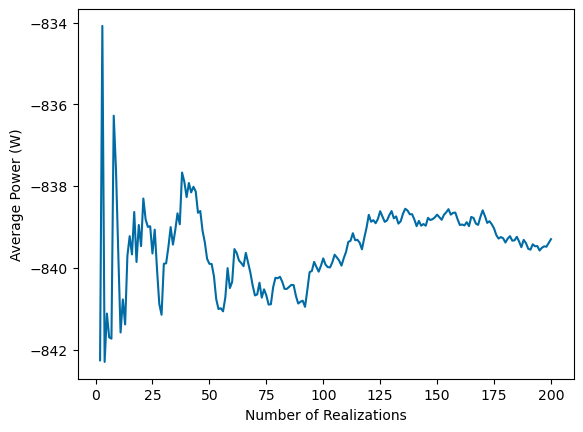

In [91]:
power_list = [item for sublist in meanpower for item in sublist]

rolling_mean = []

for ind in range(len(power_list)):

    rolling_mean.append(np.mean(power_list[0:ind]))
    
plt.figure()
plt.plot(range(1,len(power_list)+1),rolling_mean)
plt.xlabel('Number of Realizations')
plt.ylabel('Average Power (W)')

17.408812556316565


Text(0.5, 0, 'Number of Realizations')

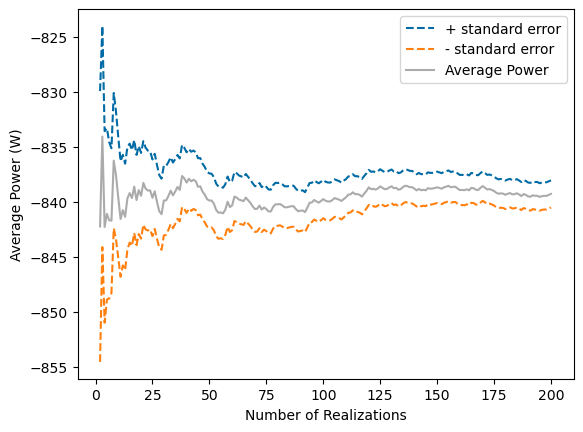

In [92]:
# calculate standard deviation and divide by square root of sample size to get the standard error of the mean

rolling_sem = []
rolling_var = []

stdev = np.std(power_list)
print(stdev)

for ind in range(len(power_list)):
    
    rolling_var.append(stdev**2)
    
    rolling_sem.append(stdev/np.sqrt(ind+1))
    
rolling_sem_pos = [sum(x) for x in zip(rolling_sem, rolling_mean)]
rolling_sem_neg = [y-x for x, y in zip(rolling_sem, rolling_mean)]

rolling_var_pos = [sum(x) for x in zip(rolling_var, rolling_mean)]
rolling_var_neg = [y-x for x, y in zip(rolling_var, rolling_mean)]
    
plt.figure()
plt.plot(range(1,len(power_list)+1),rolling_sem_pos,'--',label='+ standard error')
plt.plot(range(1,len(power_list)+1),rolling_sem_neg,'--',label='- standard error')
#plt.plot(range(1,len(power_list)+1),rolling_var_pos)
#plt.plot(range(1,len(power_list)+1),rolling_var_neg)
plt.plot(range(1,len(power_list)+1),rolling_mean,label='Average Power')
plt.legend()
plt.ylabel('Average Power (W)')
plt.xlabel('Number of Realizations')